<div align="center">
    <a href="https://colab.research.google.com/github/z-a-f/PyTorch-Notebooks/blob/master/01-Basic-Neural-Networks/Binary-Classification.ipynb" style="text-align:center">Open in Colab
        <img src="https://colab.research.google.com/img/colab_favicon.ico" width=64/>
    </a>
</div>

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

# Binary Classification: Classifying Movie Reviews

> **In this example you will learn**
>
> - What is binary classification
> - How to preprocess the data before feeding it into a neural network
> - How to stack linear, fully-connected networks and activations to produce non-linear computation.
> - What kind of activations are useful in the simplest architectures.
> - Basic problem of overfitting.

In this section you will cover binary classification, which is one of the most widely applied kind of ML problem. For that purpose you will use IMDB dataset <sup>$\dagger$</sup>, which is a collection of moview reviews, with the reviews being either positive or negative. The classification task is to predict the sentiment of the review.

---
<small><sup>$\dagger$</sup>Andrew L. Maas, Raymond E. Daly, Peter T. Pham, Dan Huang, Andrew Y. Ng, and Christopher Potts. (2011). **Learning Word Vectors for Sentiment Analysis**. *The 49th Annual Meeting of the Association for Computational Linguistics (ACL 2011)*.</small>

## IMDB Dataset

IMDB dataset is a set of 50,000 polarized movie reviews. The dataset is split into two equal parts of 25,000 reviews, one for training and another for testing. At the same time the every subset has equal number of positive and negative reviews.

The reason for separating the dataset into two parts (train and test), is to avoid “memorization”. Imagine that your network is very powerful, and after seeing 50,000 reviews, it was able to memorize all of them. You will get 100% accuracy for any example in that dataset. However, when presented with the examples never seen before, such a network will fail. Separating the data into train and test sets allows us to train on one part of the data, and check the accuracy on the other.

To load the dataset, you will use the [TorchText](https://torchtext.readthedocs.io/en/latest/datasets.html). Note that the dataset will download ~80 MB of data, and exapand into ~0.5GB. You can take a look at the [primer notebooks](/00-Primer/PyTorch/PyTorch-Packages.ipynb)

As a reminder here is how to load the `torchtext` data.

In [2]:
import os

from torchtext import data
from torchtext import datasets

# Data path
DATA_PATH = os.path.join(os.path.expanduser('~'), 'data')

# Create data fields
TEXT = data.Field(batch_first=True, lower=True)
LABEL = data.LabelField()

# Download the data and use the fields to identify it.
train, test = datasets.IMDB.splits(root=DATA_PATH,
                                   text_field=TEXT,
                                   label_field=LABEL)

Notice that we specified the `batch_first=True`, which makes sure that the batch axis is the first one in the dataset.

In [3]:
print(f'>>> len(train)  # Number of samples:\n{len(train)}')
print(f'>>> type(train[0])  # Type of the samples:\n{type(train[0])}')

>>> len(train)  # Number of samples:
25000
>>> type(train[0])  # Type of the samples:
<class 'torchtext.data.example.Example'>


You can see the samples:

In [4]:
SAMPLE_NUM = 2
print(f'>>> train[{SAMPLE_NUM}].label  # First example sentiment:\n{train[SAMPLE_NUM].label}')
print(f'>>> " ".join(train[{SAMPLE_NUM}].text)  # First example text:\n{" ".join(train[SAMPLE_NUM].text)}')

>>> train[2].label  # First example sentiment:
pos
>>> " ".join(train[2].text)  # First example text:
smallville episode justice is the best episode of smallville ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! it's my favorite episode of smallville! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! !


## Loading the Dataset

The first step is to load the dataset.

**Checkpoint Assignment**

Populate the code cell below

In [5]:
# from torchtext import data
# from torchtext import datasets

# """
# TODO: Setup the text and label fields first.
#       Make sure the text field is lower case
#       and the batch axis is first.
# TODO: Get the training and tesing sets from the torchvision datasets
# """
# TEXT = None
# LABEL = None

# train, test = None, None

While loading the dataset, we can also create a vocabulary -- a dictionary of all the words in the training text.
To use that, you can use `build_vocab` on the data fields:

In [6]:
if TEXT is None or LABEL is None:
    raise NotImplementedError("Please, finish the TEXT and LABEL instantiation")

if train is None or test is None:
    raise NotImplementedError("Please, create train and test sets")
    
MAX_VOCABULARY_SIZE = 10000

# Create a vocabulary
TEXT.build_vocab(train, max_size=MAX_VOCABULARY_SIZE-2)  # Notice this!
LABEL.build_vocab(train)

print('>>> # First 10 words in TEXT vocabulary:')
print(f'>>> TEXT.vocab.itos[:10]\n{TEXT.vocab.itos[:10]}')
print('>>> # All classes in LABEL vocabulary:')
print(f'>>> LABEL.vocab.itos\n{LABEL.vocab.itos}')

>>> # First 10 words in TEXT vocabulary:
>>> TEXT.vocab.itos[:10]
['<unk>', '<pad>', 'the', 'a', 'and', 'of', 'to', 'is', 'in', 'i']
>>> # All classes in LABEL vocabulary:
>>> LABEL.vocab.itos
['neg', 'pos']


**Reference Output**

```python
>>> # First 10 words in TEXT vocabulary:
>>> TEXT.vocab.itos[:10]
['<unk>', '<pad>', 'the', 'a', 'and', 'of', 'to', 'is', 'in', 'i']
>>> # All classes in LABEL vocabulary:
>>> LABEL.vocab.itos
['neg', 'pos']
```

Notice that we are using `MAX_VOCABULARY_SIZE - 2`.
The reason is that there are two reserved words: `<unk>` and `<pad>`, which represent unknown words and padding: there will be 9998 words in the vocabulary.

The code above takes 10000 most common words in the training set. The rest of the words are going to be `<unk>`.

### Validation set

Now that the dataset is loaded, you need to set aside a validation set.
The code below shows how to split a dataset

> **NOTE: Why do you need a validation set?**
> 
> Validation data is a special dataset derived from the training set, that is used for evaluating the running performance improvement (or degradation). This is different from the test set: test set exists only to show the very final statistical performance. It should not be used during the training phase in order to avoid tuning your network to fit to the test set.
> 
> The validation set is often used to find the best possible architecture for the given problem. For example, if you are not sure if you should use 64 or 128 hidden units in a hidden layer, you run the network twice with different parameters, and compare the statistical performance on the validation set.

In [7]:
validation_fraction = 0.33
BATCH_SIZE = 2048

# Split the dataset
train_split, val_split = train.split(1.0 - validation_fraction)
# Create data iterators (for convenience)
train_iter, val_iter, test_iter = data.Iterator.splits((train_split, val_split, test),
                                                       batch_size=BATCH_SIZE,
                                                       shuffle=True,)

In [8]:
print(f'>>> # A single batch of training data:')
first_train_batch = next(iter(train_iter))
print(f'>>> next(iter(train_iter)){first_train_batch}')

>>> # A single batch of training data:
>>> next(iter(train_iter))
[torchtext.data.batch.Batch of size 2048]
	[.text]:[torch.LongTensor of size 2048x1004]
	[.label]:[torch.LongTensor of size 2048]


Notice that the data in the batch is "numericalized" -- converted from words to numbers.

In [9]:
print("The first ten words:")
print(first_train_batch.text[0, :10])

The first ten words:
tensor([   9,  308,  294,    0,   75,  181, 1159,    8,    0,    0])


### Decoding the "numericalized" entries

While you are at it, here is how you can decode a review and its sentiment after creating the numerical representations.
You can use `stoi()` and `itos()` methods documented in [`torchtext.vocab`](https://torchtext.readthedocs.io/en/latest/vocab.html).

In [10]:
def decode_imdb(review, vocabulary):
    """Decodes a numerical review given a vocabulary."""
    pad_id = vocabulary.stoi.get('<pad>', -1)  # If no padding use -1
    text = []
    if not np.shape(review):  # In case a single number
        return vocabulary.itos[int(review)]
    for word_id in review:
        if word_id == pad_id:
            # Ignore the padding
            break
        text.append(decode_imdb(word_id, vocabulary))
    return ' '.join(text)

example = next(iter(train_iter))
SAMPLE_NUM = np.random.randint(len(example))

text = example.text[SAMPLE_NUM]
label = example.label[SAMPLE_NUM]

decoded_text = decode_imdb(text, TEXT.vocab)
decoded_sentiment = decode_imdb(label, LABEL.vocab)

# print('>>> # Decoded sentiment')
print(f'>>> decoded_sentiment\n{decoded_sentiment}')
# print('>>> # Decoded review')
print(f'>>> decoded_text\n{decoded_text}')

>>> decoded_sentiment
neg
>>> decoded_text
why me? why should i be subjected to such slaughter of what could have made an interesting <unk> at least if i can warn other people off, it will have been <unk> /><br />i had to watch this horrible movie for a college course. otherwise, i would have looked at the synopsis on the back of the thing and <unk> clear. the movie was slow, had painfully little character development, and centered around the idea that a creepy little white man can become cool if he hangs out with an <unk> token black man.<br /><br />if you want to experience the stereotypical la feeling of <unk> <unk> - watch the movie. note, though, that this movie does not depict what we have come to think of as an "la <unk> it is a wonderful example of the <unk> that <unk> from it.


Notice that some of the words have a `<unk>` token, which indicates that the word at this position was not frequent enough to be included in the vocabulary. 

### Checkpoint Assignment

Rewrite the `decode_imdb` to:

1. Replace all `<unk>` with ellipses ($\dots$).
2. Replace all the new line breaks within the text with '\n' character.


- Hint 1: You can use `vocabulary.stoi.get('<unk>', -2)` to get the numericalized version of the padding.
- Hint 2: New line breaks are three consecutive words `XYZ<br`, `/><br`, and `/>XYZ`. However, note that the `XYZ` is a valid word.

## Preprocessing the Dataset

To make the dataset usable with the neural networks, you have to turn the lists into tensors of the same size. This is because the networks you work with expect a tensor of a specific shape as an input. For the textual data, there are two ways to do that:

1. Pad/Truncate the sample lists in the dataset such that every example would have the same length. After that, train the first layer of the network to handle the padded lists (Embedding layer, will be covered in the later sections).

2. One-hot encode your lists to turn them into vectors of 0s and 1s. For example, if you have a vocabulary of size 10, you would create a vector of 10 zeros. After that you would set to one the positions that correspond to the elements in the list. Sequence `[3, 5]`, in such a scenario, would be encoded as `[0, 0, 0, 1, 0, 1, 0, 0, 0, 0]`.

You will use the second option in this exercise. Embeddings will be covered later :)

In [11]:
import torch

def vectorize_sequences(sequences, dimension=MAX_VOCABULARY_SIZE):
    results = torch.zeros((len(sequences), dimension))
    for idx, sequence in enumerate(sequences):
        results[idx, sequence] = 1.0
    return results

def data_preprocess(x_data, y_data):
    x_data = vectorize_sequences(x_data)  # Vectorize the data
    y_data = y_data.to(torch.float).reshape(-1, 1)  # Convert to Float
    return x_data, y_data

print("Original vector:\n\t", example.text[0][:100])
print("Original vector shape:\n\t", example.text[0].shape)
print("One-Hot vector:\n\t", vectorize_sequences(example.text)[0])
print("One-Hot vector shape:\n\t", vectorize_sequences(example.text)[0].shape)

Original vector:
	 tensor([ 145,    3,  305,  376,    5,    2,  225,    0, 1199,    4,  209,   35,
           5,  115,   19, 1885,    0,   62,    3, 7317,    6,   28, 2813,   19,
           0,   18,    0,    0,    4,    2,   80,  212, 8639,   15,  107,   15,
           2, 7570,  206,  402,    6, 1557,   12,  137,  446, 2397,    9, 1872,
           2,  225,    0,  707,    2,   88,    0,  280,  997,  260,    5,   11,
         390,    4,  216,   45, 5082,    0, 2855,    0, 3459,    0, 3459,    0,
        3910,    0, 8678,    0,    4,    3, 3763,    5, 2236,    0,  360,   17,
        2855,    0,   14,   19,    2,  426,    5,   57,    0,   13,    0,  146,
        1366,  154,    0,   35])
Original vector shape:
	 torch.Size([1475])
One-Hot vector:
	 tensor([1., 1., 1.,  ..., 0., 0., 0.])
One-Hot vector shape:
	 torch.Size([10000])


## Building the Network

Before building the network here is a description of the layers we will use.

- __`Linear(in_features, out_features)`__ -- A function that computes linear transformation of the input $y=w\cdot x + b$, where $w, b$ are the learnable weight and bias, and $x$ is the input vector. The `in_features` and `out_features` are arguments that specify the dimensionality of the input and output. `in_features` is often referred to as “number of hidden units”.

- __`ReLU()`__ -- Rectified Linear Unit activation function which has a form $y=max(0, x)$. `ReLU()` sets all the negative values to zero, while passing through all the positive inputs. The function plot is shown on the figure below.

- __`Sigmoid()`__ -- Sigmoid activation function creates a smooth transition from 0 to 1. When the input is extremely negative, the output approaches 0. When the input is extremely positive, the output approaches 1. The curve plot is show in the figure below.

![ReLU and Sigmoid Activations](imgs/activations.png)

> **Note: Why do you need activation functions?**
>
> Without the activation functions, no matter how many layers are included in the network, the computation will be always linear. To show it, you need to go into the domain of the linear algebra: let’s say you have a two-layer network with linear units, but without the activation functions. The output of the first layer can be computed as $H = W_1\cdot X + b_1$. The output of the second layer thus will be $Y = W_2\cdot H + b_2$. If you replace $H$ in the second equation with the first one:
> 
> $$
\begin{align}
&\begin{cases}
    H = W_1X + b_1 \\
    Y = W_2H + b_2
\end{cases} \\
\Rightarrow &Y = W_2 \left( W_1 X + b_1 \right) + b_2 \\
\Rightarrow &Y = (W_2 W_1) X + (W_2b_1 + b_2) \\
\Rightarrow & \begin{cases}
    Y = W_3 X + b_3 \\
    W_3 = W_2 W_1 \\
    b_3 = W_2b_1 + b_2
\end{cases}
\end{align}
$$
> 
> Notice that Y is a linear transformation of X, which is equivalent to a single layer network. And that’s why you need non-linear activation function such as `ReLU()` or `Sigmoid()`.

### Choosing Hyperparameters

When designing the networks, you need to answer a lot of questions.
Some of these questions:

- How many layers should be in the architecture?
- How many hidden units to have in each layer?
- What kind of activations to have after each layer?

$$\begin{align}
X
& \Rightarrow \text{Linear(10000, 1)} \\
& \Rightarrow \text{Sigmoid()} \\
& \Rightarrow Y
\end{align}$$

The architecture above shows the neural network for classifying the IMDB reviews. $X$ is the input with every example in it being a vector of size 10000. $Y$ is the output ranging from 0 to 1.

In [12]:
from torch import nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = nn.Sequential(
    nn.Linear(MAX_VOCABULARY_SIZE, 1),  # MAX_VOCABULARY_SIZE = 10000
    nn.Sigmoid()
).to(device)

Now that the model is setup, you need to setup the **optimizer** and the **loss function**.
For the optimizer we will use `RMSprop()` and for the loss `BCELoss` (Binary cross-entropy loss).

In [13]:
from torch import optim

learning_rate = 1e-3

optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
loss_fn = nn.BCELoss()  # Binary Cross Entropy loss

## Training and Validating the Model

The training utilities are located under the `/utils/training.py`. Also, you can find the performance utilities are under `/utils/performance.py`. I encourage going through the docstrings in those files :)

In [14]:
import os
import sys

# Setup the utilities path
NOTEBOOK_ROOT = f'/proc/{os.environ["JPY_PARENT_PID"]:s}/cwd'
NOTEBOOK_ROOT = os.readlink(NOTEBOOK_ROOT)
sys.path.append(NOTEBOOK_ROOT)

from utils.training import run_epoch
from utils.performance import running_loss_accuracy

**Actually training :)**

Now that the functions are imported (we will discuss them later), we can run the training.

In [15]:
import copy

# History of training
history = {
  'epoch': [],
  'train': { 'loss': [], 'accuracy': [] },
  'val': { 'loss': [], 'accuracy': [] }
}

# Number of epochs to train
EPOCHS = 20
best_accuracy = 0.0
best_model = model

for epoch in range(EPOCHS):
    train_loss, train_accuracy = run_epoch(
        model, train_iter,
        mode='train',
        loss_fn=loss_fn,
        optimizer=optimizer,
        preprocess_fn=data_preprocess,
        performance_fn=running_loss_accuracy,
        device=device
    )
    val_loss, val_accuracy = run_epoch(
        model, val_iter,
        mode='eval',
        loss_fn=loss_fn,
        preprocess_fn=data_preprocess,
        performance_fn=running_loss_accuracy,
        device=device
    )
    # Save the best model
    if val_accuracy >= best_accuracy:
        best_model = copy.deepcopy(model)

    # Record the history
    history['epoch'].append(epoch+1)  # 0-indexed
    history['train']['loss'].append(train_loss)
    history['train']['accuracy'].append(train_accuracy)
    history['val']['loss'].append(val_loss)
    history['val']['accuracy'].append(val_accuracy)

    print("{}/{}\n\tTraining Loss: {:.2f} Accuracy: {:.2%}\n\tValidation Loss: {:.2f} Accuracy: {:.2%}".format(
        history['epoch'][-1], EPOCHS,
        history['train']['loss'][-1], history['train']['accuracy'][-1],
        history['val']['loss'][-1], history['val']['accuracy'][-1],
    ))

1/20
	Training Loss: 0.61 Accuracy: 69.84%
	Validation Loss: 0.54 Accuracy: 83.26%
2/20
	Training Loss: 0.50 Accuracy: 86.00%
	Validation Loss: 0.49 Accuracy: 84.38%
3/20
	Training Loss: 0.45 Accuracy: 87.49%
	Validation Loss: 0.46 Accuracy: 85.19%
4/20
	Training Loss: 0.43 Accuracy: 88.39%
	Validation Loss: 0.45 Accuracy: 85.12%
5/20
	Training Loss: 0.40 Accuracy: 88.91%
	Validation Loss: 0.43 Accuracy: 85.76%
6/20
	Training Loss: 0.39 Accuracy: 89.59%
	Validation Loss: 0.42 Accuracy: 86.22%
7/20
	Training Loss: 0.37 Accuracy: 89.93%
	Validation Loss: 0.41 Accuracy: 86.42%
8/20
	Training Loss: 0.36 Accuracy: 90.40%
	Validation Loss: 0.40 Accuracy: 86.63%
9/20
	Training Loss: 0.35 Accuracy: 90.76%
	Validation Loss: 0.39 Accuracy: 86.82%
10/20
	Training Loss: 0.34 Accuracy: 91.10%
	Validation Loss: 0.38 Accuracy: 86.82%
11/20
	Training Loss: 0.33 Accuracy: 91.28%
	Validation Loss: 0.38 Accuracy: 87.12%
12/20
	Training Loss: 0.32 Accuracy: 91.52%
	Validation Loss: 0.37 Accuracy: 87.04%
1

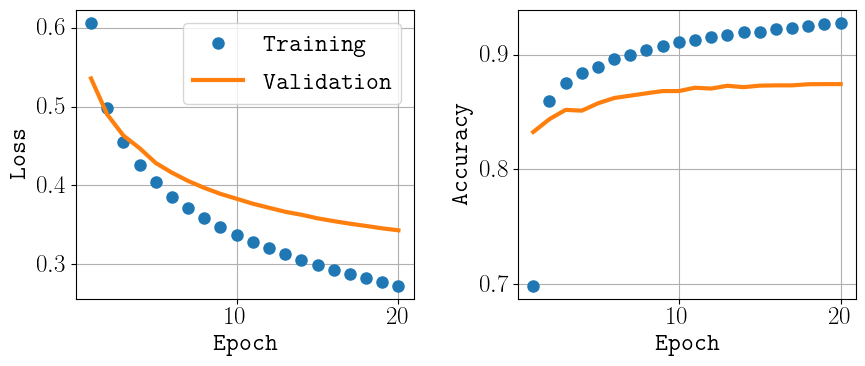

In [16]:
epochs = history['epoch']
train_loss = history['train']['loss']
train_acc = history['train']['accuracy']
val_loss = history['val']['loss']
val_acc = history['val']['accuracy']

fig, ax = plt.subplots(1, 2, figsize=(9, 4), sharex=True)

ax[0].plot(epochs, train_loss, 'o', label='Training')
ax[0].plot(epochs, val_loss, label='Validation')
ax[1].plot(epochs, train_acc, 'o', label='Training')
ax[1].plot(epochs, val_acc, label='Validation')

ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")

ax[0].grid()
ax[1].grid()

ax[0].legend(loc='best')

plt.tight_layout()

In [17]:
max_train_accuracy = np.max(history['train']['accuracy'])
min_train_loss = np.min(history['train']['loss'])
max_val_accuracy = np.max(history['val']['accuracy'])
min_val_loss = np.min(history['val']['loss'])

print('Maximum accuracy')
print(f'\ttraining: {max_train_accuracy:.2%}')
print(f'\tvalidation: {max_val_accuracy:.2%}')
print('Minimum loss')
print(f'\ttraining: {min_train_loss:.2f}')
print(f'\tvalidation: {min_val_loss:.2f}')

Maximum accuracy
	training: 92.74%
	validation: 87.43%
Minimum loss
	training: 0.27
	validation: 0.34


**Checkpoint Assignment**

Redesign the architecture to have more layers. For example, try the following architecture:

$$\begin{align}
X
& \Rightarrow \text{Linear(10000, 16)} \\
& \Rightarrow \text{ReLU()} \\
& \Rightarrow \text{Linear(16, 16)} \\
& \Rightarrow \text{ReLU()} \\
& \Rightarrow \text{Linear(16, 1)} \\
& \Rightarrow \text{Sigmoid()} \\
& \Rightarrow Y
\end{align}$$

After retraining it, your results should be similar to

```console
Maximum accuracy
	training: 99.22%
	validation: 88.56%
Minimum loss
	training: 0.05
	validation: 0.29
```

## Evaluating the model

Model is now trained, and ready to classify the sentiment of completely new reviews. Although you could use the previously untouched test_data, let us write our own review.

In [18]:
# 0. Prepare the model for inference :)
inference_model = best_model.to('cpu')
inference_model.eval()

zafars_review = "This is one of the baddest moviews I have seen. Director John Doe managed to capture both the historical context as well as the character absurdity. I would absolutely dub this movie as a masterpiece. However, there were some scenes that were subpar, and did grind my gears. Overall, however, it is a great watch for both old and young."

# 1. Convert to lower case
zafars_review_lower = zafars_review.lower()

# 2. Split into words
zafars_review_split = zafars_review_lower.split()

# 3. Convert to numerical vectors:
zafars_review_numerical = TEXT.numericalize([zafars_review_split])

# 4. One-Hot encode the review
zafars_review_onehot = vectorize_sequences(zafars_review_numerical)

# 5. Predict
zafars_sentiment = inference_model(zafars_review_onehot)

print("Zafar's review is {:.2%} positive".format(zafars_sentiment.item()))

Zafar's review is 55.11% positive


### More to do

Play with the codes that you covered in this section. Try the following

1. Try more (or less) hidden layers in the network. See how it changes the training, validation, and test accuracy.
2. Try increasing the number of units per layer. Instead of using 16, try 32 or 64 units.
3. Rewrite the codes to use `MSELoss` instead of the `BCELoss`
4. Try different types of activation. One candidate is to use `Tanh()` instead of `ReLU()`
5. You might need to change the learning rate for some of the parameters.